In [3]:
#import skxray.speckle_analysis as spe_vis
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core as core
from IPython.core.display import HTML

import numpy as np
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

In [4]:
data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/duke_cc_12C/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data=np.asarray(duke_data)



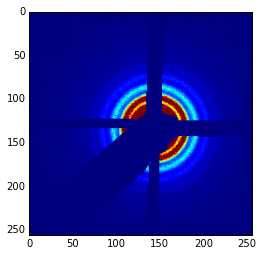

In [7]:
data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data = np.asarray(duke_data)    

avg_img = np.average(duke_data, axis=0)

mask4 = np.load(data_dir+"new_mask4.npy")

mask = np.load(data_dir+"Luxi_duke_mask.npy")

N_mask = ~(mask + mask4)

plt.imshow(N_mask*avg_img, vmax=1e0)
plt.show()

In [8]:
inner_radius = 24
width = 1
spacing = 1
num_rings = 10
center = (133, 143)

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, center, avg_img.shape)


In [9]:
mask_data2 = N_mask*duke_data[0:4999]

ring_mask = rings*N_mask

In [10]:
num_levels = 7
num_bufs = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, ring_mask,
                                             mask_data2)

In [11]:
exposuretime=0.001;
deadtime=60e-6;
timeperframe = exposuretime+deadtime
lags = lag_steps*timeperframe

roi_names = ['gray', 'orange', 'brown', 'red', 'green', 'blue', 'black', 'purple', 'pink', 'yellow']

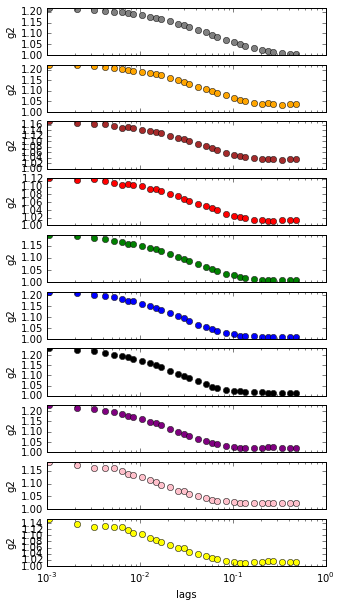

In [12]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5,10))
axes[num_rings-1].set_xlabel("lags")
for i, roi_color in zip(range(num_rings), roi_names):
    axes[i].set_ylabel("g2") 
    axes[i].semilogx(lags, g2[:, i], 'o', markerfacecolor=roi_color, markersize=6)
    axes[i].set_ylim(bottom=1, top=np.max(g2[1:, i]))
plt.show()

In [17]:
from __future__ import absolute_import, division, print_function

def multi_tau_auto_corr(num_levels, num_bufs, labels, images):
    """Wraps generator implementation of multi-tau
    See docstring for lazy_multi_tau
    """
    gen = lazy_multi_tau(images, num_levels, num_bufs, labels)
    for result in gen:
        pass
    return result.g2, result.lag_steps


#from __future__ import absolute_import, division, print_function
import skxray.core.utils as utils
#from .roi import extract_label_indices
from collections import namedtuple
import numpy as np

import logging
logger = logging.getLogger(__name__)


def _one_time_process(buf, G, past_intensity_norm, future_intensity_norm,
                      label_mask, num_bufs, num_pixels, img_per_level, level,
                      buf_no):
    """Reference implementation of the inner loop of multi-tau correlation
    This helper function calculates G, past_intensity_norm and
    future_intensity_norm at each level, symmetric normalization is used.
    .. warning :: This modifies inputs in place.
    Parameters
    ----------
    buf : array
        image data array to use for correlation
    G : array
        matrix of auto-correlation function without normalizations
    past_intensity_norm : array
        matrix of past intensity normalizations
    future_intensity_norm : array
        matrix of future intensity normalizations
    label_mask : array
        labeled array where all nonzero values are ROIs
    num_bufs : int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain roi's
        roi's, dimensions are : [number of roi's]X1
    img_per_level : array
        to track how many images processed in each level
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number
    Notes
    -----
    :math ::
        G   = <I(\tau)I(\tau + delay)>
    :math ::
        past_intensity_norm = <I(\tau)>
    :math ::
        future_intensity_norm = <I(\tau + delay)>
    """
    img_per_level[level] += 1
    # in multi-tau correlation, the subsequent levels have half as many
    # buffers as the first
    i_min = num_bufs // 2 if level else 0

    for i in range(i_min, min(img_per_level[level], num_bufs)):
        # compute the index into the autocorrelation matrix
        t_index = level * num_bufs / 2 + i

        delay_no = (buf_no - i) % num_bufs
        # get the images for correlating
        past_img = buf[level, delay_no]
        future_img = buf[level, buf_no]
        for w, arr in zip([past_img*future_img, past_img, future_img],
                          [G, past_intensity_norm, future_intensity_norm]):
            binned = np.bincount(label_mask, weights=w)
            # pdb.set_trace()
            arr[t_index] += ((binned / num_pixels - arr[t_index]) /
                             (img_per_level[level] - i))
    return None  # modifies arguments in place!


results = namedtuple(
    'correlation_results',
    ['g2', 'lag_steps', 'internal_state']
)

_internal_state = namedtuple(
    'correlation_state',
    ['buf',
     'G',
     'past_intensity',
     'future_intensity',
     'img_per_level',
     'label_mask',
     'track_level',
     'cur',
     'pixel_list',
     'label_mapping',
     ]
)


def _init_state(num_levels, num_bufs, labels):
    """Initialize a stateful namedtuple for the generator-based multi-tau
    Parameters
    ----------
    num_levels : int
    num_bufs : int
    labels : array
        Two dimensional labeled array that contains ROI information
    Returns
    -------
    internal_state : namedtuple
        The namedtuple that contains all the state information that
        `lazy_multi_tau` requires so that it can be used to pick up processing
        after it was interrupted
    """
    label_mask, pixel_list = roi.extract_label_indices(labels)
    # map the indices onto a sequential list of integers starting at 1
    label_mapping = {label: n for n, label in enumerate(
            np.unique(label_mask))}
    # remap the label mask to go from 0 -> max(_labels)
    for label, n in label_mapping.items():
        label_mask[label_mask == label] = n

    # G holds the un normalized auto- correlation result. We
    # accumulate computations into G as the algorithm proceeds.
    G = np.zeros(((num_levels + 1) * num_bufs / 2, len(label_mapping)),
                 dtype=np.float64)
    # matrix for normalizing G into g2
    past_intensity = np.zeros_like(G)
    # matrix for normalizing G into g2
    future_intensity = np.zeros_like(G)
    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, len(pixel_list)),
                   dtype=np.float64)
    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)
    # to track which levels have already been processed
    track_level = np.zeros(num_levels, dtype=bool)
    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    return _internal_state(
        buf,
        G,
        past_intensity,
        future_intensity,
        img_per_level,
        label_mask,
        track_level,
        cur,
        pixel_list,
        label_mapping,
    )


def lazy_multi_tau(image_iterable, num_levels, num_bufs, labels,
                   internal_state=None):
    """Generator implementation of 1-time multi-tau correlation
    Parameters
    ----------
    image_iterable : iterable of 2D arrays
    num_levels : int
        how many generations of downsampling to perform, i.e., the depth of
        the binomial tree of averaged frames
    num_bufs : int, must be even
        maximum lag step to compute in each generation of downsampling
    labels : array
        Labeled array of the same shape as the image stack.
        Each ROI is represented by sequential integers starting at one.  For
        example, if you have four ROIs, they must be labeled 1, 2, 3,
        4. Background is labeled as 0
    labels : array
        Labeled array of the same shape as the image stack.
        Each ROI is represented by sequential integers starting at one.  For
        example, if you have four ROIs, they must be labeled 1, 2, 3,
        4. Background is labeled as 0
    internal_state : namedtuple, optional
        internal_state is a bucket for all of the internal state of the
        generator. It is part of the `results` object that is yielded from
        this generator
    Yields
    ------
    namedtuple
        A `results` object is yielded after every image has been processed. This
        `reults` object contains:
        - the normalized correlation, `g2`
        - the times at which the correlation was computed, `lag_steps`
        - and all of the internal state, `final_state`, which is a
          `correlation_state` namedtuple
    Notes
    -----
    The normalized intensity-intensity time-autocorrelation function
    is defined as
    :math ::
        g_2(q, t') = \frac{<I(q, t)I(q, t + t')> }{<I(q, t)>^2}
    ; t' > 0
    Here, I(q, t) refers to the scattering strength at the momentum
    transfer vector q in reciprocal space at time t, and the brackets
    <...> refer to averages over time t. The quantity t' denotes the
    delay time
    This implementation is based on published work. [1]_
    References
    ----------
    .. [1] D. Lumma, L. B. Lurio, S. G. J. Mochrie and M. Sutton,
        "Area detector based photon correlation in the regime of
        short data batches: Data reduction for dynamic x-ray
        scattering," Rev. Sci. Instrum., vol 70, p 3274-3289, 2000.
    """
    if num_bufs % 2 != 0:
        raise ValueError("There must be an even number of `num_bufs`. You "
                         "provided %s" % num_bufs)
    if internal_state is None:
        internal_state = _init_state(num_levels, num_bufs, labels)
    # create a shorthand reference to the results and state named tuple
    s = internal_state
    # stash the number of pixels in the mask
    num_pixels = np.bincount(s.label_mask)
    # Convert from num_levels, num_bufs to lag frames.
    tot_channels, lag_steps = utils.multi_tau_lags(num_levels, num_bufs)

    # iterate over the images to compute multi-tau correlation
    for image in image_iterable:
        # Compute the correlations for all higher levels.
        level = 0

        # increment buffer
        s.cur[0] = (1 + s.cur[0]) % num_bufs

        # Put the ROI pixels into the ring buffer.
        s.buf[0, s.cur[0] - 1] = np.ravel(image)[s.pixel_list]
        buf_no = s.cur[0] - 1
        # Compute the correlations between the first level
        # (undownsampled) frames. This modifies G,
        # past_intensity, future_intensity,
        # and img_per_level in place!
        _one_time_process(s.buf, s.G, s.past_intensity, s.future_intensity,
                          s.label_mask, num_bufs, num_pixels, s.img_per_level,
                          level, buf_no)

        # check whether the number of levels is one, otherwise
        # continue processing the next level
        processing = num_levels > 1

        level = 1
        while processing:
            if not s.track_level[level]:
                s.track_level[level] = True
                processing = False
            else:
                prev = (1 + (s.cur[level - 1] - 2) % num_bufs)
                s.cur[level] = (
                    1 + s.cur[level] % num_bufs)

                # TODO clean this up. it is hard to understand
                s.buf[level, s.cur[level] - 1] = ((
                        s.buf[level - 1, prev - 1] +
                        s.buf[level - 1, s.cur[level - 1] - 1]
                    ) / 2
                )

                # make the track_level zero once that level is processed
                s.track_level[level] = False

                # call processing_func for each multi-tau level greater
                # than one. This is modifying things in place. See comment
                # on previous call above.
                buf_no = s.cur[level] - 1
                _one_time_process(s.buf, s.G, s.past_intensity,
                                  s.future_intensity, s.label_mask, num_bufs,
                                  num_pixels, s.img_per_level, level, buf_no)
                level += 1

                # Checking whether there is next level for processing
                processing = level < num_levels

        # If any past intensities are zero, then g2 cannot be normalized at
        # those levels. This if/else code block is basically preventing
        # divide-by-zero errors.
        if len(np.where(s.past_intensity == 0)[0]) != 0:
            g_max = np.where(s.past_intensity == 0)[0][0]
        else:
            g_max = s.past_intensity.shape[0]

        g2 = (s.G[:g_max] / (s.past_intensity[:g_max] *
                             s.future_intensity[:g_max]))
        yield results(g2, lag_steps[:g_max], s)

In [18]:
#num_levels, num_bufs, ring_mask,
#                                             mask_data2)
g2n, lagn = multi_tau_auto_corr(num_levels, num_bufs, ring_mask,
                                             mask_data2)

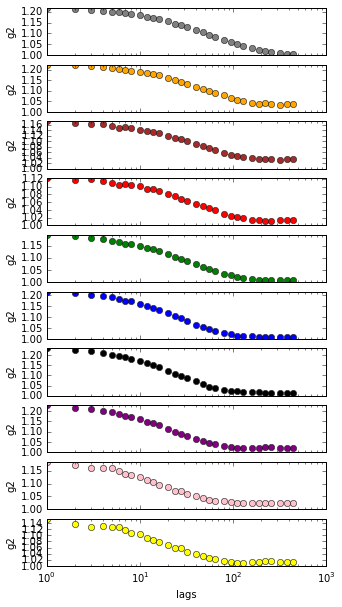

In [19]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5,10))
axes[num_rings-1].set_xlabel("lags")
for i, roi_color in zip(range(num_rings), roi_names):
    axes[i].set_ylabel("g2") 
    axes[i].semilogx(lagn, g2n[:, i], 'o', markerfacecolor=roi_color, markersize=6)
    axes[i].set_ylim(bottom=1, top=np.max(g2n[1:, i]))
plt.show()

In [20]:
g2 == g2n

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True, 